In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/biasbios")
sys.path.append("../data/embeddings/biasbios")
import classifier
import debias
import codecs
import json
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

import copy
import pandas as pd



/tmp/ipykernel_3469857/3101289199.py:28: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


### Load data

In [2]:
def load_dataset(path):
    
    with open(path, "rb") as f:
        
        data = pickle.load(f)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter

### Load original data (train.pickle etc.) and pre-calculated BERT CLS states ("train_cls.npy" etc.)

In [3]:
!pwd

#Define language here!!!!!

lang = "EN"
ns_lang = "FR"



train = load_dataset("../data/biasbios/{}/train.pickle".format(lang))
dev = load_dataset("../data/biasbios/{}/dev.pickle".format(lang))
test = load_dataset("../data/biasbios/{}/test.pickle".format(lang))
counter = count_profs_and_gender(train+dev+test)
p2i, i2p = load_dictionary("../data/biasbios/{}/profession2index.txt".format(lang))
g2i, i2g = load_dictionary("../data/biasbios/{}/gender2index.txt".format(lang))

path = "../data/bert_encode_biasbios/{}/".format(lang)
x_train = np.load(path + "train_avg_mbert.npy") 
x_dev = np.load(path + "dev_avg_mbert.npy") 
x_test = np.load(path + "test_avg_mbert.npy") 


assert len(train) == len(x_train)
assert len(dev) == len(x_dev)
assert len(test) == len(x_test)

f,m = 0., 0.
prof2fem = dict()

for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

y_train = np.array([p2i[entry["p"]] for entry in train])
y_dev = np.array([p2i[entry["p"]] for entry in dev])
y_test = np.array([p2i[entry["p"]] for entry in test])



/scratch/spatil27/tmp/multilingual_gender-main/src
0.46286566875856267
{'professor': 0.45118956904580476, 'chiropractor': 0.26558891454965355, 'psychologist': 0.6223011751844766, 'architect': 0.23712053792148718, 'physician': 0.507688318423441, 'nurse': 0.9085446207369142, 'dentist': 0.35589474411216243, 'surgeon': 0.14857228961048746, 'rapper': 0.09665955934612651, 'model': 0.8283124500133298, 'photographer': 0.35721920736720936, 'composer': 0.16392857142857142, 'comedian': 0.21150410861021793, 'filmmaker': 0.3295762590954487, 'paralegal': 0.8483305036785512, 'journalist': 0.49488721804511276, 'personal_trainer': 0.45670391061452514, 'teacher': 0.603111879476414, 'painter': 0.4579886246122027, 'attorney': 0.38316925813475633, 'accountant': 0.36818825194621374, 'software_engineer': 0.1576889661164205, 'poet': 0.49080017115960634, 'dj': 0.1420875420875421, 'pastor': 0.24052132701421802, 'yoga_teacher': 0.8454600120264583, 'dietitian': 0.9273504273504274, 'interior_designer': 0.808612440

### Load INLP matrices

In [6]:
directory = "final"
    

Ws_en = np.load("../data/inlp_matrices/EN/{}/Ws_mbert_300_EN_avg.npy".format(directory)) # avg 
with open("../data/inlp_matrices/EN/{}/iters_mbert_300_EN_avg.json".format(directory)) as f:
    accs_en = json.load(f)
Ws_en_k = np.array(Ws_en[:100]).squeeze(axis=1)
print(Ws_en_k.shape)
row_en = debias.get_rowspace_projection(Ws_en_k)
P_mbert_en_100 = np.eye(768) - row_en
print(P_mbert_en_100.shape)
print(np.linalg.matrix_rank(P_mbert_en_100))
print(np.linalg.matrix_rank(row_en))


Ws_fr = np.load("../data/inlp_matrices/FR/{}/Ws_mbert_300_FR_avg.npy".format(directory)) #avg 
with open("../data/inlp_matrices/FR/{}/iters_mbert_300_FR_avg.json".format(directory)) as f:
    accs_fr = json.load(f)
Ws_fr_k = np.array(Ws_fr[:100]).squeeze(axis=1)
print(Ws_fr_k.shape)
row_fr = debias.get_rowspace_projection(Ws_fr_k)
P_mbert_fr_100 = np.eye(768) - row_fr
print(P_mbert_fr_100.shape)
print(np.linalg.matrix_rank(P_mbert_fr_100))
print(np.linalg.matrix_rank(row_fr))


Ws_es = np.load("../data/inlp_matrices/ES/{}/Ws_mbert_300_ES_avg.npy".format(directory)) #avg
with open("../data/inlp_matrices/ES/{}/iters_mbert_300_ES_avg.json".format(directory)) as f:
    accs_es = json.load(f)
Ws_es_k = np.array(Ws_es[:100]).squeeze(axis=1)
print(Ws_es_k.shape)
row_es = debias.get_rowspace_projection(Ws_es_k)
P_mbert_es_100 = np.eye(768) - row_es
print(P_mbert_es_100.shape)
print(np.linalg.matrix_rank(P_mbert_es_100))
print(np.linalg.matrix_rank(row_es))

Ws_de = np.load("../data/inlp_matrices/DE/{}/Ws_mbert_300_DE_avg.npy".format(directory)) #avg
with open("../data/inlp_matrices/DE/{}/iters_mbert_300_DE_avg.json".format(directory)) as f:
    accs_de = json.load(f)
Ws_de_k = np.array(Ws_de[:100]).squeeze(axis=1)
print(Ws_de_k.shape)
row_de = debias.get_rowspace_projection(Ws_de_k)
P_mbert_de_100 = np.eye(768) - row_de
print(P_mbert_de_100.shape)
print(np.linalg.matrix_rank(P_mbert_de_100))
print(np.linalg.matrix_rank(row_de))

Ws_it = np.load("../data/inlp_matrices/IT/{}/Ws_mbert_300_IT_avg.npy".format(directory)) #avg
with open("../data/inlp_matrices/IT/{}/iters_mbert_300_IT_avg.json".format(directory)) as f:
    accs_it = json.load(f)
Ws_it_k = np.array(Ws_it[:100]).squeeze(axis=1)
print(Ws_it_k.shape)
row_it = debias.get_rowspace_projection(Ws_it_k)
P_mbert_it_100 = np.eye(768) - row_it
print(P_mbert_it_100.shape)
print(np.linalg.matrix_rank(P_mbert_it_100))
print(np.linalg.matrix_rank(row_it))


ns_es = P_mbert_es_100
ns_fr = P_mbert_fr_100
ns_en = P_mbert_en_100
ns_de = P_mbert_de_100
ns_it = P_mbert_it_100

(100, 768)
(768, 768)
668
100
(100, 768)
(768, 768)
668
100
(100, 768)
(768, 768)
668
100
(100, 768)
(768, 768)
668
100
(100, 768)
(768, 768)
668
100


### Plot similarities between classifiers

0.02563604625742669
[0.7767145040127258, 0.597489612300365, 0.45261251900972066, 0.21312304417992683, 0.20929388840014307, 0.203318105379134, 0.17382850872090388, 0.15881042153722189, 0.15839705330195042, 0.15108671511650418]


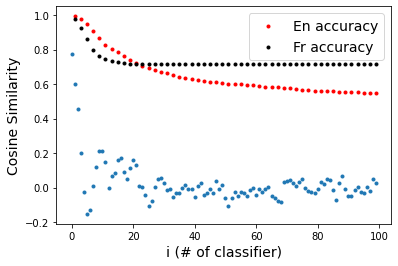

In [7]:

from numpy import dot
from numpy.linalg import norm

all_cossim = []
for i in range(100):
    a = Ws_en[i].squeeze(axis=0)
    b = Ws_fr[i].squeeze(axis=0)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    all_cossim.append(cos_sim)

plt.plot(all_cossim, ".")
plt.scatter(range(1,100,2), accs_en[:50], marker='.', color="red", label="En accuracy")
plt.scatter(range(1,100,2), accs_fr[:50], marker='.', color="black", label="Fr accuracy")
plt.ylabel("Cosine Similarity", fontsize=14)
plt.xlabel("i (# of classifier)", fontsize=14)
plt.legend(fontsize=14)
print(sum(all_cossim)/len(all_cossim))
all_cossim.sort(reverse=True)
print(all_cossim[:10])
plt.show()

0.02328017642289741
[0.681578130419633, 0.4969937340102848, 0.4312264780890749, 0.425168029161726, 0.317267495044597, 0.19577991383945212, 0.19172862350905445, 0.1820303715294681, 0.16967550307618642, 0.11145830650579591]


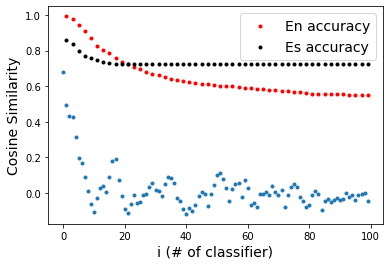

In [8]:
all_cossim = []
for i in range(100):
    a = Ws_en[i].squeeze(axis=0)
    b = Ws_es[i].squeeze(axis=0)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    all_cossim.append(cos_sim)

plt.plot(all_cossim, ".")
plt.scatter(range(1,100,2), accs_en[:50], marker='.', color="red", label="En accuracy")
plt.scatter(range(1,100,2), accs_es[:50], marker='.', color="black", label="Es accuracy")
plt.ylabel("Cosine Similarity", fontsize=14)
plt.xlabel("i (# of classifier)", fontsize=14)
plt.legend(fontsize=14)
print(sum(all_cossim)/len(all_cossim))
all_cossim.sort(reverse=True)
print(all_cossim[:10])
plt.show()

0.013534014010220701
[0.7035199588182223, 0.5254212821222355, 0.41510389438303713, 0.4010715683108631, 0.3710913924864118, 0.30419701209958144, 0.2404227425271222, 0.22286875144928212, 0.21857763326277582, 0.19340185333609142]


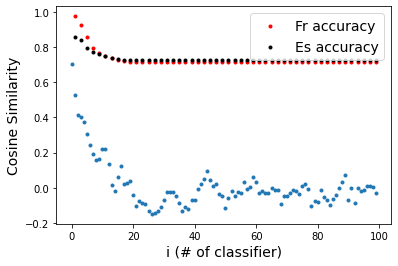

In [9]:
all_cossim = []
for i in range(100):
    a = Ws_fr[i].squeeze(axis=0)
    b = Ws_es[i].squeeze(axis=0)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    all_cossim.append(cos_sim)

plt.plot(all_cossim, ".")
plt.scatter(range(1,100,2), accs_fr[:50], marker='.', color="red", label="Fr accuracy")
plt.scatter(range(1,100,2), accs_es[:50], marker='.', color="black", label="Es accuracy")
plt.ylabel("Cosine Similarity", fontsize=14)
plt.xlabel("i (# of classifier)", fontsize=14)
plt.legend(fontsize=14)
print(sum(all_cossim)/len(all_cossim))
all_cossim.sort(reverse=True)
print(all_cossim[:10])
plt.show()


0.8594380199933653
[0.9402745391071944, 0.9382584501959318, 0.9375542734053848, 0.9330897980036217, 0.932220628232716, 0.9297539379108883, 0.9296505909601754, 0.9284068516781911, 0.9259550476776345, 0.9241564191279431]


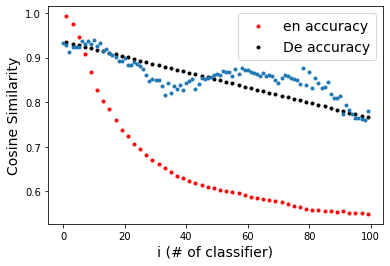

In [13]:
all_cossim = []
for i in range(100):
    a = Ws_en[i].squeeze(axis=0)
    b = Ws_de[i].squeeze(axis=0)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    all_cossim.append(cos_sim)

plt.plot(all_cossim, ".")
plt.scatter(range(1,100,2), accs_en[:50], marker='.', color="red", label="en accuracy")
plt.scatter(range(1,100,2), accs_de[:50], marker='.', color="black", label="De accuracy")
plt.ylabel("Cosine Similarity", fontsize=14)
plt.xlabel("i (# of classifier)", fontsize=14)
plt.legend(fontsize=14)
print(sum(all_cossim)/len(all_cossim))
all_cossim.sort(reverse=True)
print(all_cossim[:10])
plt.show()

0.02348556707135265
[0.6457784247994273, 0.4755800507356756, 0.3916896189255975, 0.3801003864983356, 0.27372574005641365, 0.1728501300432929, 0.1666392224747736, 0.16286644517276713, 0.1581312516254391, 0.12374034217644966]


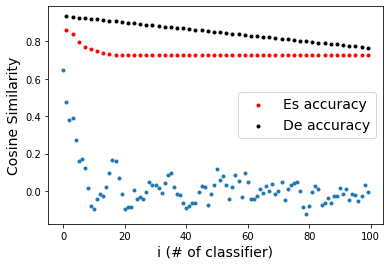

In [15]:
all_cossim = []
for i in range(100):
    a = Ws_es[i].squeeze(axis=0)
    b = Ws_de[i].squeeze(axis=0)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    all_cossim.append(cos_sim)

plt.plot(all_cossim, ".")
plt.scatter(range(1,100,2), accs_es[:50], marker='.', color="red", label="Es accuracy")
plt.scatter(range(1,100,2), accs_de[:50], marker='.', color="black", label="De accuracy")
plt.ylabel("Cosine Similarity", fontsize=14)
plt.xlabel("i (# of classifier)", fontsize=14)
plt.legend(fontsize=14)
print(sum(all_cossim)/len(all_cossim))
all_cossim.sort(reverse=True)
print(all_cossim[:10])
plt.show()

0.02707244592671604
[0.7200558845382609, 0.54326818733531, 0.40598802700525133, 0.20775490090551044, 0.1943935777920657, 0.19201404888060916, 0.15702447237856948, 0.15431139286717557, 0.13509052820314613, 0.1286685719593754]


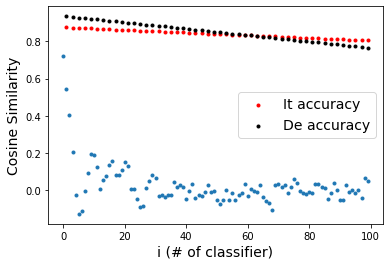

In [16]:
all_cossim = []
for i in range(100):
    a = Ws_it[i].squeeze(axis=0)
    b = Ws_de[i].squeeze(axis=0)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    all_cossim.append(cos_sim)

plt.plot(all_cossim, ".")
plt.scatter(range(1,100,2), accs_it[:50], marker='.', color="red", label="It accuracy")
plt.scatter(range(1,100,2), accs_de[:50], marker='.', color="black", label="De accuracy")
plt.ylabel("Cosine Similarity", fontsize=14)
plt.xlabel("i (# of classifier)", fontsize=14)
plt.legend(fontsize=14)
print(sum(all_cossim)/len(all_cossim))
all_cossim.sort(reverse=True)
print(all_cossim[:10])
plt.show()

0.02609311294845467
[0.7202835579637666, 0.5438176835482061, 0.40683183383155774, 0.20812002251406803, 0.20177722543721052, 0.1886806675164628, 0.17831368101732673, 0.15805540415271233, 0.1515360671435818, 0.1181105730249509]


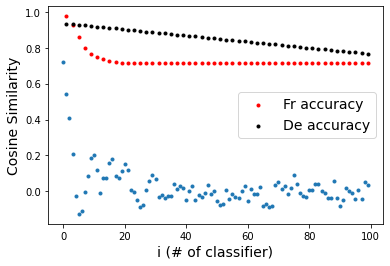

In [14]:
all_cossim = []
for i in range(100):
    a = Ws_fr[i].squeeze(axis=0)
    b = Ws_de[i].squeeze(axis=0)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    all_cossim.append(cos_sim)

plt.plot(all_cossim, ".")
plt.scatter(range(1,100,2), accs_fr[:50], marker='.', color="red", label="Fr accuracy")
plt.scatter(range(1,100,2), accs_de[:50], marker='.', color="black", label="De accuracy")
plt.ylabel("Cosine Similarity", fontsize=14)
plt.xlabel("i (# of classifier)", fontsize=14)
plt.legend(fontsize=14)
print(sum(all_cossim)/len(all_cossim))
all_cossim.sort(reverse=True)
print(all_cossim[:10])
plt.show()

0.02704189689086962
[0.7768415349456845, 0.5971316805901912, 0.452241653343898, 0.2149444438784286, 0.2033126839620848, 0.20184704289825367, 0.16261306227029398, 0.16006681656665872, 0.1555703505724697, 0.14094249971734832]


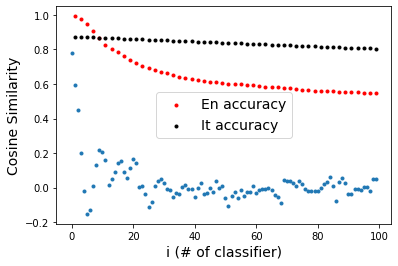

In [17]:
all_cossim = []
for i in range(100):
    a = Ws_en[i].squeeze(axis=0)
    b = Ws_it[i].squeeze(axis=0)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    all_cossim.append(cos_sim)

plt.plot(all_cossim, ".")
plt.scatter(range(1,100,2), accs_en[:50], marker='.', color="red", label="En accuracy")
plt.scatter(range(1,100,2), accs_it[:50], marker='.', color="black", label="It accuracy")
plt.ylabel("Cosine Similarity", fontsize=14)
plt.xlabel("i (# of classifier)", fontsize=14)
plt.legend(fontsize=14)
print(sum(all_cossim)/len(all_cossim))
all_cossim.sort(reverse=True)
print(all_cossim[:10])
plt.show()

0.9483179848522809
[0.9994882736990549, 0.9994036865873849, 0.9992752254357996, 0.9987803318334356, 0.9986981976153575, 0.9979766503550728, 0.9971435884419287, 0.996926214063678, 0.9968965250818724, 0.9959330126510494]


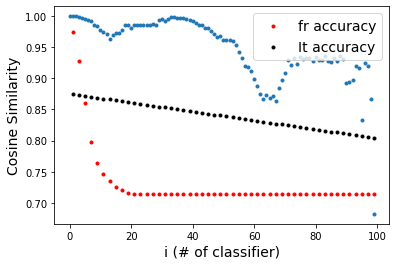

In [18]:
all_cossim = []
for i in range(100):
    a = Ws_fr[i].squeeze(axis=0)
    b = Ws_it[i].squeeze(axis=0)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    all_cossim.append(cos_sim)

plt.plot(all_cossim, ".")
plt.scatter(range(1,100,2), accs_fr[:50], marker='.', color="red", label="fr accuracy")
plt.scatter(range(1,100,2), accs_it[:50], marker='.', color="black", label="It accuracy")
plt.ylabel("Cosine Similarity", fontsize=14)
plt.xlabel("i (# of classifier)", fontsize=14)
plt.legend(fontsize=14)
print(sum(all_cossim)/len(all_cossim))
all_cossim.sort(reverse=True)
print(all_cossim[:10])
plt.show()

0.0140907132008284
[0.7027008694427833, 0.5255198552009422, 0.41459559087168524, 0.39667640900256446, 0.3696549442509667, 0.30137683438508045, 0.24586571172060726, 0.22473668362244525, 0.21095306766957428, 0.19261394394573844]


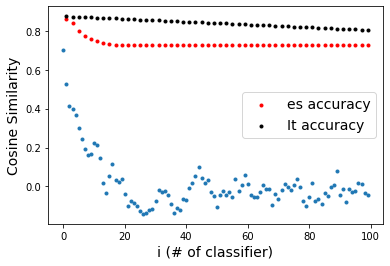

In [19]:
all_cossim = []
for i in range(100):
    a = Ws_es[i].squeeze(axis=0)
    b = Ws_it[i].squeeze(axis=0)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    all_cossim.append(cos_sim)

plt.plot(all_cossim, ".")
plt.scatter(range(1,100,2), accs_es[:50], marker='.', color="red", label="es accuracy")
plt.scatter(range(1,100,2), accs_it[:50], marker='.', color="black", label="It accuracy")
plt.ylabel("Cosine Similarity", fontsize=14)
plt.xlabel("i (# of classifier)", fontsize=14)
plt.legend(fontsize=14)
print(sum(all_cossim)/len(all_cossim))
all_cossim.sort(reverse=True)
print(all_cossim[:10])
plt.show()

In [20]:
# compute cos_sim

all_cossim = []
for i in range(100):
    for j in range(100):
        a = Ws_en[i].squeeze(axis=0)
        b = Ws_fr[j].squeeze(axis=0)
        cos_sim = dot(a, b)/(norm(a)*norm(b))
        all_cossim.append(cos_sim)
all_cossim.sort(reverse=True)
print(all_cossim[:10])

print(sum(np.abs(all_cossim))/len(all_cossim))

all_cossim = []
for i in range(100):
    a = Ws_en[i].squeeze(axis=0)
    b = Ws_fr[i].squeeze(axis=0)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    all_cossim.append(cos_sim)
all_cossim.sort(reverse=True)
print(all_cossim[:10])

[0.7767145040127258, 0.597489612300365, 0.45261251900972066, 0.36696201403308565, 0.3553937673023777, 0.32229387650002433, 0.28530058900250266, 0.27038286278020085, 0.2593779788897082, 0.23500920713842444]
0.037429228062804035
[0.7767145040127258, 0.597489612300365, 0.45261251900972066, 0.21312304417992683, 0.20929388840014307, 0.203318105379134, 0.17382850872090388, 0.15881042153722189, 0.15839705330195042, 0.15108671511650418]


### Create random projection matrices

In [21]:
random.seed(10)
mu, sigma = 0, 0.1 # mean and standard deviation
all_w = []
for i in range(768):
    w = np.random.normal(mu, sigma, 768)
    all_w.append(w)

W_random_100 = np.array(all_w[:100])
row_rand_100 = debias.get_rowspace_projection(W_random_100)
ns_rand_100 = np.eye(768) - row_rand_100
print(row_rand_100.shape)
print(ns_rand_100.shape)
print(np.linalg.matrix_rank(row_rand_100))
print(np.linalg.matrix_rank(ns_rand_100))


(768, 768)
(768, 768)
100
668


### Define repr to compare

In [36]:
lang = "FR"
ns_lang = "DE"
if lang == "EN":
    row = row_en
    ns_same = ns_en
if lang == "FR":
    row = row_fr
    ns_same = ns_fr
if lang == "ES":
    row = row_es
    ns_same = ns_es
if lang == "DE":
    row = row_de
    ns_same = ns_de
if lang == "IT":
    row = row_it
    ns_same = ns_it
    

if ns_lang == "EN":
    ns = ns_en
if ns_lang == "FR":
    ns = ns_fr
if ns_lang == "ES":
    ns = ns_es 
if ns_lang == "DE":
    ns = ns_de
if ns_lang == "IT":
    ns = ns_it
    
    
row_rand = row_rand_100
ns_rand = ns_rand_100

row_ns = np.dot(ns, row)
row_ns_rand = np.dot(ns_rand, row)
both_rand = np.dot(ns_rand, row_rand)
row_ns_same = np.dot(ns_same, row)


### Access repr and create variations

In [37]:
print(len(x_train))
x_orig = x_train    
x_row = np.dot(x_orig, row)
x_row_rand = np.dot(x_orig, row_rand)
x_row_ns = np.dot(x_orig, row_ns)
x_row_ns_rand = np.dot(x_orig, row_ns_rand)
x_both_rand = np.dot(x_orig, both_rand)
x_row_ns_same = np.dot(x_orig, row_ns_same)

255682


In [38]:
from sklearn.decomposition import PCA

def pca_var(x):
    pca = PCA()
    pca.fit(x)
    pca_var = pca.explained_variance_    
    return pca_var


pca_orig = pca_var(x_orig)
pca_row = pca_var(x_row)
pca_row_rand = pca_var(x_row_rand)
pca_row_ns = pca_var(x_row_ns)
pca_row_ns_rand = pca_var(x_row_ns_rand)
pca_both_rand = pca_var(x_both_rand)
pca_row_ns_same = pca_var(x_row_ns_same)

Fr
De


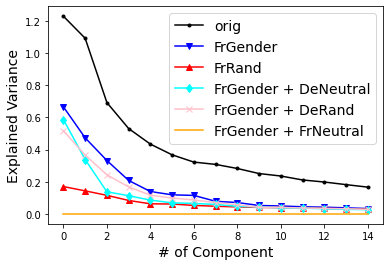

orig 14.02923657755941
row 2.9009939336906414
row_rand 1.8065314977383713
row_ns 2.121778938530876
row_ns_rand 2.38297866910875
row_ns_same 9.717742471738811e-30


In [39]:
lang = lang[0] + lang[1].lower()
ns_lang = ns_lang[0] + ns_lang[1].lower()
print(lang)
print(ns_lang)
plt.plot(pca_orig[:15], marker='.', color="black", label="orig")
plt.plot(pca_row[:15], marker='v', color="blue", label="{}Gender".format(lang))
plt.plot(pca_row_rand[:15], marker='^', color="red", label="{}Rand".format(lang))
plt.plot(pca_row_ns[:15], marker='d', color="cyan", label="{}Gender + {}Neutral".format(lang, ns_lang))
plt.plot(pca_row_ns_rand[:15], marker='x', color="pink", label="{}Gender + {}Rand".format(lang, ns_lang))
plt.plot(pca_row_ns_same[:15], color="orange", label="{}Gender + {}Neutral".format(lang, lang))

plt.legend(loc="upper right", fontsize=14)
plt.ylabel("Explained Variance", fontsize=14)
plt.xlabel("# of Component", fontsize=14)
plt.show()

print("orig", sum(pca_orig))
print("row", sum(pca_row))
print("row_rand", sum(pca_row_rand))
print("row_ns", sum(pca_row_ns))
print("row_ns_rand", sum(pca_row_ns_rand))
print("row_ns_same", sum(pca_row_ns_same))
